In [ ]:
# [CELL ID] 1

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## The theory

[CELL ID] 2
### Moving to neural networks

Now that we've seen how adversarial examples work in the context of linear models, let's move to the setting we really care about: the possibility of adversarial examples in deep neural networks. 

First, let us define formally a neural network. Let us define $h_\theta(x) : \mathbb{R}^n \rightarrow \mathbb{R}^k$ to be an $d$-layer network, given by the following equations
\begin{equation}
\begin{split}
z_1 & = x \\
z_{i+1} & = f_i(W_i z_i + b_i), \;\; i,\ldots,d \\
h_\theta(x) & = z_{d+1}
\end{split}
\end{equation}
where $z_i$ denote the activations at layer $i$; $f_i$ denotes the activation function for layer $i$, which we will often take to be e.g. the ReLU operator $f_i(z) = \max\{0,z\}$ for layers $i=1,\ldots,d-1$ and the linear operator $f_i(z) = z$ for layer $d$ (remember, the last layer outputs are the class logits, and the loss function "builds in" the softmax operator, so we don't explicitly put the softmax into the network); and the parameters of the network are given by $\theta = \{W_1,b_1,\ldots,W_d,b_d\}$ (in the above, $W_i$ is most obviously interpreted a matrix, but it could really be any linear operator including convolutions).  We won't worry for now about explicitly defining the size of all the intermediate layers, but we assume that they are specified such that the final function $h_\theta$ takes inputs in $\mathbb{R}^n$ and outputs vectors in $\mathbb{R}^k$.  The loss function for multiclass case, namely the Cross Entropy loss, is as follows:
\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y.
\end{equation}

[CELL ID] 3
### Crafting an attack

Unlike it the linear case, it is _not_ easy to solve, the maximization problem over our perturbation. This is because the cost surface for neural networks (here considering it over the _input_ space, not parameter space) is not convex, and is especially prone to local optima.  We can see this even in the simple example above, where there are local optimal when either trying to maximize or minimize the function above, and the initial gradient at a given point may or may not point in the direction of the actual maxima. 

So how _do_ we go about (approximately) solving the inner optimization problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y)
\end{equation}
in the case of $h_\theta$ being a neural network? 

The most common strategy to approximate the pertubation is to find a _lower bound_ on the optimization objective.  Because (by definition) _any_ feasible $\delta$ will give us a lower bound, this is equivalent to just "trying to empirically solve the optimization problem", i.e., "find an adversarial example."  
This is by far the most common strategy for solving the inner maximization motivated largely by the fact that for neural networks in general, problems of local optima don't seem as bad as initially may be thought. 

[CELL ID] 4
### Lower bounding the inner maximization (i.e., adversarial attacks)

Let's start by considering perhaps the simplest way of solving the optimization problem we care about, the task of maximizing
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
In fact we already saw one example for how to do this in our introductory lecture, but the basic idea here is quite simple: using backpropagation, we can compute the gradient of the loss function with respect to the perturbation $\delta$ itself, so let's just perform gradient descent on $\delta$ to maximize our objective.  However, we also need to ensure that $\delta$ stays within the norm bound $\epsilon$, so after each step, we can project back into this space.



## Exercice 2
1. Define a neural network with 3 fully connected layers
2. Define a neural network with 2 convolutional layers and a last fully connected layer
2. Train the network on the full MNIST Dataset
3. Code the FGSM attack
4. Evaluate your model against FGSM
5. Plot some images with and without the adversarial perturbation
6. Make an analysis of FGSM attack and compare it with the attack from the first notebook

[CELL ID 5]
## Implementing fully connected and convolutional networks

### Loading MNIST dataset (train set and test set)

In [ ]:
# [CELL ID] 6

# load MNIST dataset
def load_mnist(split, batch_size):
  train = split == 'train'
  dataset = datasets.MNIST("./data", train=train, download=True, transform=transforms.ToTensor())
  return DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 100
train_loader = load_mnist('train', batch_size)
test_loader = load_mnist('test', batch_size)

### Implementing fully connected neural network

- Les images en entrée étant codées sous la forme d'un tenseur de dimensions (1, 28, 28), nous commençons par les convertir (`x = x.view(x.shape[0], -1)`) en un tenseur 1D de dimension 784 (28 $\times$  28 points). Cette valeur de 784 correspond à la dimension de l'input de la première couche linéaire ;
- Les couches linéaires successives doivent aboutir in-fine à la production d'un vecteur de 10 valeurs dans la mesure où il faut produire une prédiction pour une classe parmi 10 (les chiffres de 0 à 9) ;
- La fonction d'activation retenue est la fonction ReLU, le standard dans le cadre de réseaux neuronaux pour le traitement d'images (notamment les réseaux convolutifs - cf. infra).

In [ ]:
# [CELL ID] 8

# define a neural network with 3 fully connected layers
class FullyConnectedModel(torch.nn.Module):
  
  def __init__(self, input_dim, output_dim):
    super(FullyConnectedModel, self).__init__()
    self.layers = nn.Sequential(nn.Flatten(), 
                                nn.Linear(input_dim, 256), nn.ReLU(),
                                nn.Linear(256, 64), nn.ReLU(),
                                nn.Linear(64, output_dim)
    )
        
  def forward(self, x):
    return self.layers(x)

### Implementing convolutional neural network

Nous implémentons un réseau convolutif qui contient comme demandé 2 couches convolutives suivies de 3 couches linéaires.
- Les valeurs des paramètres de la première couche convolutive sont fixées à :
    - 1 : le nombre de *channels*, unique ici vu que les images sont en niveaux de gris ;
    - 6 : nombre d'*activation maps*, valeur choisie arbitrairement (correspondant à la valeur retenue par exemple pour le réseau LeNet - 5) ;
    - 3 : taille du filtre/noyau convolutif ;
    - 1 : valeur du padding, i.e. nombre de 0 ajouté de chaque côté de l'image pour préserver la dimension d'origine de l'image après passage des filtres convolutifs.  
   L'output est donc constitué de 6 *activation maps* de dimension (28, 28).
- On applique ensuite comme demandé un *max pooling 2D* (2, 2) qui produit un output de dimension (14, 14) ;
- Pour la seconde couche convolutive, la première valeur d'input est fixée à 6, soit le nombre d'*activation maps* produit par la première couche. 16 *activation maps* sont produites en sortie (cf. à nouveau LeNet - 5). Comme à l'étape précédente, un noyau de taille 3 est appliqué avec une taille de padding de 1. L'output est donc constitué de 6 *activation maps* de dimension (14, 14) ;
- On applique ensuite comme demandé un *max pooling 2D* (2, 2), ce qui produit un output constitué de 16 *activation maps* de dimension (7, 7) ;
- On connecte ensuite une première couche linéaire prenant en entrée les 16 $\times$ 7 $\times$ 7 = 784 valeurs produites en sortie des convolutions et maxpoolings successifs pour produire un output de dimension 120 (valeur choisie dans LeNet -5) ;
- On connecte à cette première couche linéaire une deuxième couche linéaire prenant en entrée les 120 valeurs issues de la couche précédente et produisant un output de dimension 64 (valeur choisie dans LeNet -5) ;
- Finalement, une dernière couche linéaire permet de passer d'un input de dimension 64 à un output de dimension 10, à savoir le nombre de classes possibles vu que la prédiction porte sur des chiffres allant de 0 à 9.

En accord avec les consignes, la fonction d'activation utilisée est la fonction ReLU.

**Note** : Formule pour la dimension $D$ de l'output d'une convolution 2D en supposant une image carrée haute (et large) de $W$ pixels : $D = (W - F + 2P)/S + 1$ avec $F$ la taille du filtre/kernel, $P$ la taille du padding, $S$ la valeur du stride.


In [ ]:
# [CELL ID] 9

# convolutional model with 2 convolution, 2 max pooling layer, 3 fully connected layer
# the model should be: 2x (conv -> max pooling -> relu) -> 2x (fc -> relu) -> fc
class ConvModel(torch.nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        
        # 2 convolutional layers + 3 fully connected layers
        self.layers = nn.Sequential(
            # 1st conv layer
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1), # -> input=8, output=28
            nn.MaxPool2d(kernel_size=2), nn.ReLU(), # => output = 28/2 = 14
            
            #2nd conv layer
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1), # input=14, output=14
            nn.MaxPool2d(kernel_size=2), nn.ReLU(), # => output = 14/2 = 7
            
            # we use the fully connected layers defined above
            FullyConnectedModel(16*7*7, 10)
        ) 
    
    def forward(self, x):
        return self.layers(x)

### Training the models on train set
The function below is a generic function (helper) to train a specific model over a given dataset.

In [ ]:
# [CELL ID] 7

def train_model(model, criterion, optimizer, loader, epochs=10):
  """    Function to train the model over mini-batches  """
  # enable the training mode of the model
  model.train()
  losses = []
  for epoch in range(epochs): # iter
    for imgs, labels in loader:
        # send data to the appropriate device
        imgs, labels = imgs.to(device), labels.to(device)
        
        model.train() if optimizer else model.eval()
        # make a prediction with the current state of the model
        outputs = model(imgs)
        # compute the current loss
        loss = criterion(outputs, labels) 
        if optimizer:
          # compute the gradient of the loss (PyTorch computation graph is used here)
          loss.backward()  
          # update the model parameters with their corresponding gradient (computed above)     
          optimizer.step()
          # reset the model parameters gradient (cumulative by default)
          optimizer.zero_grad()
        # backup the loss for furture analysis
        losses.append(loss.detach().cpu().numpy())
    print('epoch {}, loss: {:.4f}'.format(epoch, losses[-1]))
  return losses

#### Training parameters
- La prédiction portant sur la classe d'appartenance d'une image parmi 10 classes possibles, la fonction de loss utilisée est la Cross Entropy.
- L'optimisation est réalisée par descente du gradient stochastique (SGD)
- On commence par entraîner le modèle totalement connecté avant de passer à l'entraînement du modèle convolutif

In [ ]:
# [CELL ID] 10

fc_model = FullyConnectedModel(784, 10).to(device)

# define your loss function
criterion = torch.nn.CrossEntropyLoss()

# define your optimizer
opt = torch.optim.SGD(fc_model.parameters(), lr=0.1)

epochs = 10

#### Training fully connected network

In [ ]:
losses = train_model(fc_model, criterion, opt, train_loader, epochs)

print('loss =', losses[-1])

epoch 0, loss: 0.2897
epoch 1, loss: 0.1789
epoch 2, loss: 0.1518
epoch 3, loss: 0.1446
epoch 4, loss: 0.0246
epoch 5, loss: 0.0441
epoch 6, loss: 0.0742
epoch 7, loss: 0.0162
epoch 8, loss: 0.0297
epoch 9, loss: 0.0136
loss = 0.013604045


#### Training convolutional network

In [ ]:
# [CELL ID] 11

conv_model = ConvModel().to(device)

# define your loss function
criterion = torch.nn.CrossEntropyLoss()

# define your optimizer
opt = torch.optim.SGD(conv_model.parameters(), lr=0.1)

losses = train_model(conv_model, criterion, opt, train_loader, epochs)
print('avg loss =', losses[-1])

epoch 0, loss: 0.1273
epoch 1, loss: 0.1169
epoch 2, loss: 0.1502
epoch 3, loss: 0.0183
epoch 4, loss: 0.0830
epoch 5, loss: 0.1315
epoch 6, loss: 0.0385
epoch 7, loss: 0.0187
epoch 8, loss: 0.0110
epoch 9, loss: 0.0090
avg loss = 0.0090264985


### Evaluating the models on test set

Les modèles seront évalués sur la base du pourcentage de chiffres identifiés correctement.

Pour ce faire, on commence par initialiser à 0 les variables `correct` et  `n` destinées à comptabiliser repsectivement le nombre de prédictions correctes et le nombre d'exemples traités. Le nombre de prédictions correctes pour un batch donné est obtenu en comptabilisant le nombre de valeur **True** retourné lors de la comparaison du vecteur des prédictions ayant la plus forte probabilité (`proba = F.log_softmax(output, dim=1)` suivi de `pred = proba.max(1, keepdim=True)[1]`) avec les valeurs correspondantes des labels (`torch.sum(pred.squeeze()==labels).item()`). Le nombre d'exemple traités est obtenu à partir du nombre d'exemples `labels.shape[0]`consituant un batch donné (et non la taille du batch lui-même telle que fournie par la variable `batch_size` dans la mesure où le dernier lot peut contenir un nombre d'exemples inférieur à la taille de batch définie). Le test est réalisé sur le jeu de test (`test_loader`) à la fois pour le modèle totalement connecté et pour le modèle convolutif.

En cas d'attaque (condition `if attack` validée à **True**), l'image d'origine est perturbée en ajoutant à chacun des éléments du tenseur qui lui est associé la valeur de `delta` calculée par application du type d'attaque (FGSM ou PGD) à l'image d'origine.

#### Evaluating the fully connected network

In [ ]:
# [CELL ID] 12

def eval_model(model, loader, attack=None):
  """Function to evaluate your model on a specific loader"""
  model.eval()
  correct, n = 0, 0
  for imgs, labels in loader:
    imgs, labels = imgs.to(device), labels.to(device)
    
    if attack:
      imgs = attack.compute(imgs, labels)
    output = model(imgs)

    # transforming the output to probability by applying log_softmax function
    proba = F.log_softmax(output, dim=1)
    pred = proba.max(1, keepdim=True)[1]

    correct += torch.sum(pred.squeeze()==labels).item()
    n += labels.shape[0]

  return correct/n

#### Evaluating the convolutional network

In [ ]:
acc_fc = eval_model(fc_model, test_loader)
acc_conv = eval_model(conv_model, test_loader)

print('full connected accuracy :', acc_fc)
print('convolutional accuracy:', acc_conv)

full connected accuracy : 0.9783
convolutional accuracy: 0.9885


### Conclusion
En l'absence d'attaque, l'accuracy en test du réseau entièrement connecté et du réseau convolutif sont très fortes avec un taux de classification correctes avoisinant les 100%.

## The Fast Gradient Method (FGSM)


Let's consider in a bit more detail how we might do the attack we mentioned above.  For some given example $x$, we know that we are going to adjust $\delta$ in the direction of it's gradient, i.e., we will first compute the gradient
\begin{equation}
g := \nabla_\delta \ell(h_\theta(x + \delta),y)
\end{equation}
using simple backpropagation; note that if we're evaluating this gradient at $\delta=0$ (as we would at the first timestep), then this is also just equal to $\nabla_x \ell(h_\theta(x),y)$, but we'll express the gradients in terms of $\delta$ to be consistent with how we do things going forward.

In order to maximize loss, we want to adjust delta in the direction of this gradient, i.e., take a step
\begin{equation}
\delta := \delta + \alpha g
\end{equation}
for some step size $\alpha$ and then project back into the norm ball defined by $\|\delta\| \leq \epsilon$.  But how big a step do we take?  For concreteness, let's consider the particular case of the $\ell_\infty$ norm $\|\delta\|_\infty \leq \epsilon$, where, as we mentioned before, projecting onto this norm ball simply involves clipping values of $\delta$ to lie within the range $[-\epsilon, \epsilon]$.  If our initial $\delta$ is zero, this gives the update
\begin{equation}
\delta := \mathrm{clip}(\alpha g, [-\epsilon, \epsilon]).
\end{equation}
Now, how big of a step size should we take?  If we want to make increase the loss as much as possible, it makes sense to take as large a step as possible, i.e., take $\alpha$ to be very large (of course knowing that we won't take _that_ big a step, since we're projecting back into the $\ell_\infty$ ball afterwards).  It is not hard to see that for $\alpha$ large enough, the relative sizes of the entries of $g$ won't matter: we will simply take $\delta_i$ to be either $+\epsilon$ or $-\epsilon$ depending upon the sign of $g_i$.  In other words, for large $\alpha$, this update becomes
\begin{equation}
\delta := \epsilon \cdot \mathrm{sign}(g).
\end{equation}

This is know as the Fast Gradient Sign Method (FGSM) [1], and it was one of the first methods for constructing adversarial examples proposed by the deep learning community.

[1] Explaining and Harnessing Adversarial Examples

### Implementing `FastGradientSignMethod` class
Dans le cas du réseau linéaire étudié dans le Notebook 1, il était possible de disposer d'une forme explicite pour le gradient du coût par rapport aux poids et de calculer directement la perturbation à apporter au vecteur de poids. Dans le cas des réseaux de neurones profonds ou convolutifs, la fonction de coût est trop complexe pour disposer d'une forme explicite du gradient. On dispose cela dit du gradient de la fonction objective par rapport à $x$ ( fourni par PyTorch lors de la rétropopagation) et l'on peut utiliser la même démarche que précédemment, qui consiste à maximiser le coût par ajout à l'image $x$ d'une perturbation $\delta$ égale à $\epsilon \cdot \mathrm{signe}(\nabla_x)$.

Concernant l'implémentation sous Pytorch, il suffit de parcourir les éléments du gradient déjà calculés par un modèle donné préalablement entraîné, sans mise à jour des poids (d'où l'absence d'étape d'optimisation), de récupérer la valeur $\pm 1$ du signe du gradient via `grad.sign()` et de calculer la perturbation `delta` à appliquer aux données de départ comme `self.eps * .grad.sign()`.

A noter en fin de définition de la classe une instruction ` x.requires_grad=False` qui, si elle n'est pas présente, entraîne une erreur d'exécution au niveau de la fonction `plot_images` au moment de l'instruction `x = x.cpu().numpy()`. Après analyse de l'erreur, il apparaît que celle-ci tient au fait que le bridge *numpy* n'admet pas en entrée un tenseur qui exige un calcul de gradient.

In [ ]:
# [CELL ID] 13

class FastGradientSignMethod:
  def __init__(self, model, eps):
    self.model = model
    self.eps = eps
  
  def compute(self, x, y):
    """ Construct FGSM adversarial perturbation for examples x"""    
    x.requires_grad=True # enable locally gradient computation on x
    
    output = self.model(x)
    loss_func = nn.CrossEntropyLoss() # define a specific loss to compute the gradient w.r.t x
    loss = loss_func(output, y)
    loss.backward() # back-propagate the gradient w.r.t x

    delta = self.eps * x.grad.sign() # compute the delta of pertubation by applying the sign of the gradient of x
    x.requires_grad=False # disable gradient computation on x
    
    return x + delta # return the attacked (modified) image


### Evaluating models on test set under FGSM attack

In [ ]:
# we define our hyperparameter epsilon set
epsilons = [0.0, 0.07, 0.1, 0.5, 1]
print('epsilons:', epsilons)

def plot_eps_accuracy(epsilons, accuracies):
  accuracies = [100*c for c in accuracies]
  plt.figure(figsize=(10, 5))
  plt.plot(epsilons, accuracies, "*-")
  plt.xticks(np.arange(0, 1.1, step=0.1))
  plt.yticks(np.arange(0, 101, step=10))
  plt.title("accuracy vs epsilon")
  plt.xlabel("epsilon")
  plt.ylabel("accuracy (%)")
  plt.show()


def adv_fgsm_eval_model(model, loader):
  accuracies = []

  print('epsilon', 'accuracy', sep='\t')
  for epsilon in epsilons:
    fgsm = FastGradientSignMethod(model, epsilon)
    acc = eval_model(model, loader, fgsm)
    accuracies.append(acc)
    print('{:.3f}'.format(epsilon), '{:.5f}'.format(acc), sep='\t')
  
  plot_eps_accuracy(epsilons, accuracies)

epsilons: [0.0, 0.07, 0.1, 0.5, 1]


#### Evaluating fully connected network

epsilon	accuracy
0.000	0.97830
0.070	0.21010
0.100	0.06070
0.500	0.00100
1.000	0.00030


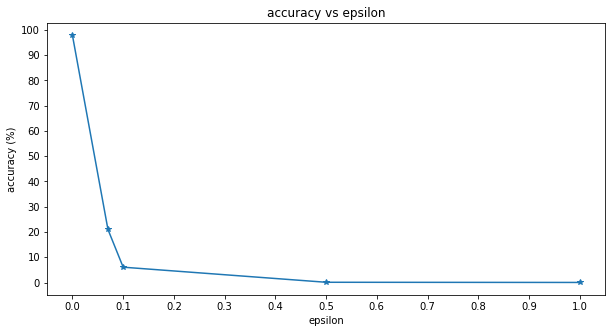

In [ ]:
adv_fgsm_eval_model(fc_model, test_loader)

#### Evaluating convolutional network


epsilon	accuracy
0.000	0.98850
0.070	0.86070
0.100	0.70940
0.500	0.05550
1.000	0.02980


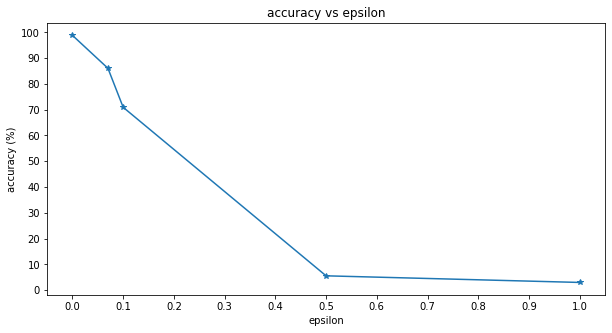

In [ ]:
adv_fgsm_eval_model(conv_model, test_loader)

### Conclusion
L'attaque est efficace.  
Avec un niveau de perturbation $\epsilon$ fixé à 0.1, l'accuracy du modèle entièrement connecté passe de 97% à 6% et celle du modèle convolutionnel de 99% à 71%.  
Sur cet exemple, il apparaît que le réseau entièrement connecté est plus vulnérable que le réseau convolutionnel à l'attaque FGSM mise en oeuvre ici.  

Glabalement, la précision décroît lorsque $\epsilon$ augmente, ce qui est cohérent avec le fait que le bruit ajouté à l'image devient plus important.

### Visual aspect of attacked images under FGSM

In [ ]:
# [CELL ID] 14

def plot_images(x, y, yp, M=5, N=5):
  x = x.cpu().numpy()
  y = y.cpu().numpy()
  f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N,M*1.3))
  for i in range(M):
    for j in range(N):
      ax[i][j].imshow(1-x[i*N+j][0], cmap="gray")
      title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
      plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
      ax[i][j].set_axis_off()
    plt.tight_layout()
  plt.show()
  
# getting the first chunk of test set
for imgs, labels in test_loader:
  imgs, labels = imgs.to(device), labels.to(device)
  break

Let's plot the original set (`eps=0.`)

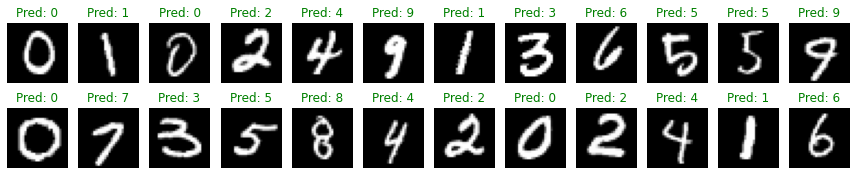

In [ ]:
output = conv_model(imgs)
plot_images(1 - imgs, labels, output, 2, 12)

#### Evaluating fully connected network


epsilon = 0.0 



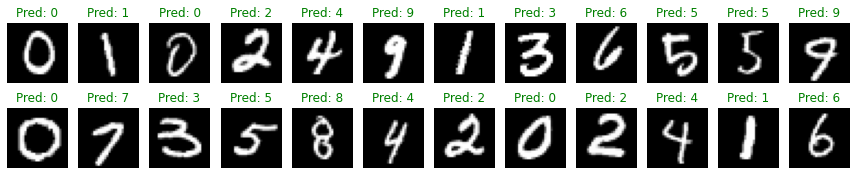


epsilon = 0.07 



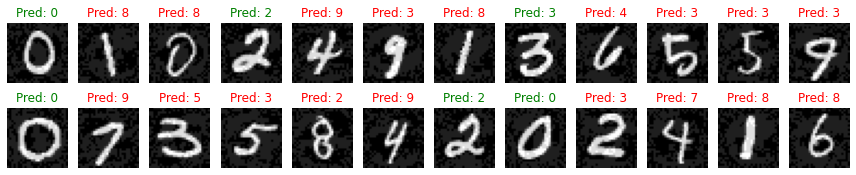


epsilon = 0.1 



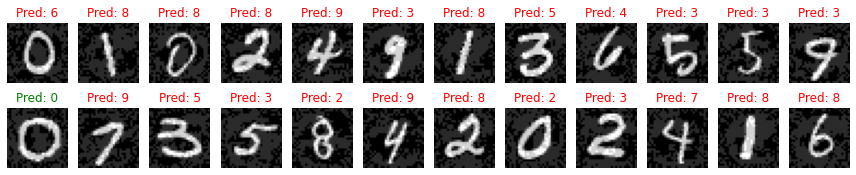


epsilon = 0.5 



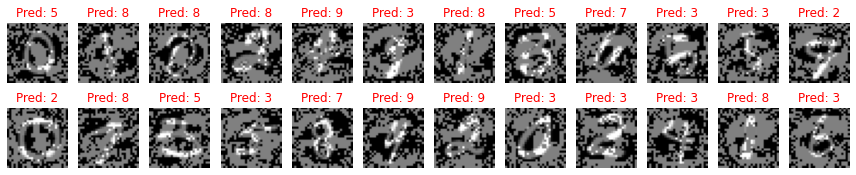


epsilon = 1 



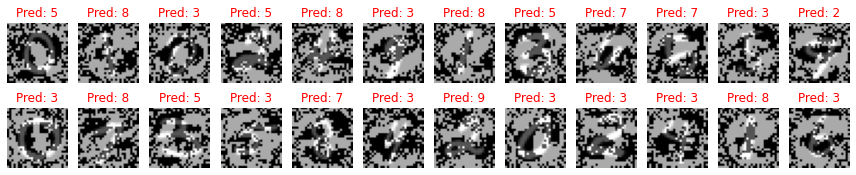

In [ ]:
for epsilon in epsilons:
  print('\nepsilon =', epsilon, '\n')

  fgsm = FastGradientSignMethod(fc_model, epsilon)
  adv_imgs = fgsm.compute(imgs, labels)
  output = fc_model(adv_imgs)

  plot_images(1 - adv_imgs, labels, output, 2, 12)

#### Evaluating convolutional network


epsilon = 0.0 



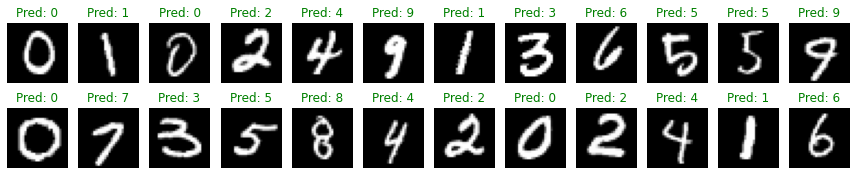


epsilon = 0.07 



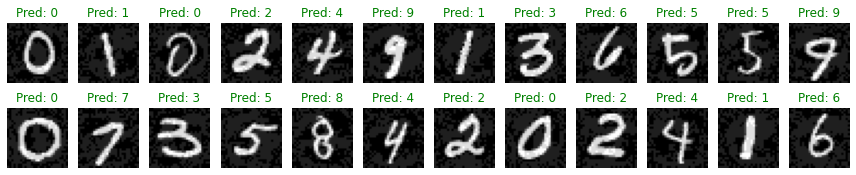


epsilon = 0.1 



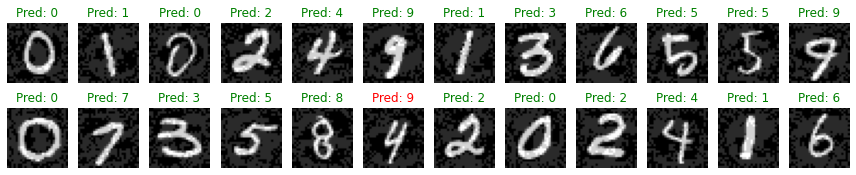


epsilon = 0.5 



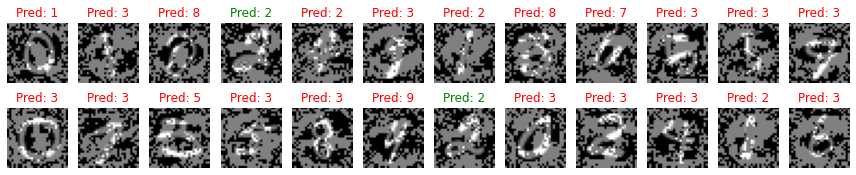


epsilon = 1 



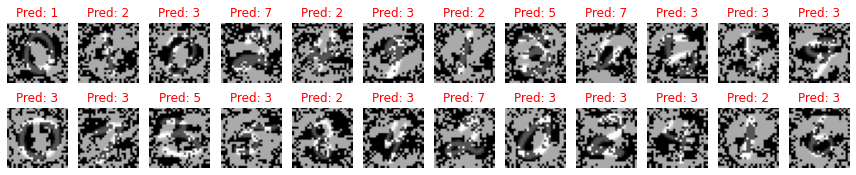

In [ ]:
for epsilon in epsilons:
  print('\nepsilon =', epsilon, '\n')

  fgsm = FastGradientSignMethod(conv_model, epsilon)
  adv_imgs = fgsm.compute(imgs, labels)
  output = conv_model(adv_imgs)

  plot_images(1 - adv_imgs, labels, output, 2, 12)

### Overall discussion on FGSM

L'attaque mise en oeuvre avec une valeur de $\epsilon$ fixée à 0.1 n'affecte pas à proprement parler la structure générale des chiffres d'origine mais introduit plutôt un bruit de fond au niveau des pixels qui entourent ceux-ci. Cette perturbation, qui n'affecte pas la reconnaissance des données pour un oeil humain, entraîne cependant une baisse très significative de la performance du classifieur.  
A compter de $\epsilon=0.5$, les données d'origine sont perturbées au point de ne plus pouvoir être identifiées par un humain et le taux de reconnaissance obtenu par le réseau entièrement connecté comme par le réseau convolutif tombe à près de 0.

## The Projected gradient descent (PGD)

This discussion immediately brings us to the next approach we would want to consider for maximizing the optimization problem, just doing projected gradient descent (i.e., the above procedure, but iterating it and with a smaller step size). [Note: technically speaking, this is gradient _ascent_ since we are maximizing a function rather than minimization, but it's common to just refer to the process as gradient descent.]. This was also called the "basic iterative procedure" in it's first appearance within the adversarial attacks literature [1], but essentially it is just the obvious choice for how we might maximize the inner objective a bit more carefully than with FGSM. The basic PGD algorithm simply iterates the updates:
\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \delta := \mathcal{P}(\delta + \alpha \nabla_\delta \ell(h_\theta(x+\delta), y))
\end{split}
\end{equation}
where $\mathcal{P}$ denotes the projection onto the ball of interest (for example, clipping in the case of the $\ell_\infty$ norm).  Of course, with PGD we now have more choices we need to make when specifying the attack, such as the actual stepsize itself, and the number of iterations (we'll discuss some rules of thumb shortly once we present a slightly modified version of the above iteration).  We can implement this attack in the following manner, where we're here going to implement the gradient descent procedure rather than rely on one of PyTorch's optimizers, as we want to see what's going on a bit more explicitly (PyTorch's SGD also includes terms like momentum, which actually usually are able to optimize the inner term _better_, but we want to have as little black-box procedures here as possible).

[1] Adversarial Machine Learning At Scale

### Implementing `ProjectedGradientMethod` class
Par rapport à la classe FastGradientMethod, le codage de cette nouvelle classe exige un calcul itératif de la valeur du terme de perturbation et un recalcul de la valeur du gradient du coût par rapport aux poids à partir de l'image perturbée produite à l'itération précédente.

Du point de vue de l'implémentation PyTorch, ceci nécessite tout d'abord la déclaration d'un tenseur `delta` autorisant le calcul de gradient. Lors de la phase de calcul itératif des gradients, la valeur de `delta` obtenue lors de l'itération précédente est ajoutée aux données d'origine (`output = self.model(x + delta))` afin de pouvoir calculer lors de l'étape `loss = self.criterion(output, y)` la nouvelle valeur du gradient sur les données modifiées résultant de l'itération précédente.

Une fois ces valeurs obtenues, la valeur précédente de `delta` est ajustée en utilisant la relation $\delta + \alpha \nabla_\delta \ell(h_\theta(x+\delta), y)$, puis la projection est réalisée en ramenant la valeur de `delta` mise à jour dans l'intervalle $[-\epsilon, \epsilon]$ grâce à la fonction `clamp`.

In [ ]:
# [CELL ID] 16

class ProjectedGradientDescent:
  
  def __init__(self, model, eps, alpha, num_iter):
    self.model = model
    self.eps = eps
    self.alpha = alpha
    self.num_iter = num_iter
  
  def compute(self, x, y):
    # we define a specific loss to compute the gradient w.r.t x
    loss_func = nn.CrossEntropyLoss()
    
    # then initialize the delta to 0 with the same shape as x
    delta = torch.zeros_like(x, requires_grad=True)

    # and perform gradient descent iterative procedure
    for i in range(self.num_iter):
      # we compute the output image from the modified image
      output = self.model(x + delta)

      # evaluate the loss on the outup
      loss = loss_func(output, y)
      
      # back-propagate the gradient w.r.t delta
      loss.backward()

      # update the delta with it current gradient
      delta.data += self.alpha * delta.grad.data

      # clip the delta in the range [-eps, eps]
      delta.data = delta.data.clamp(-self.eps, self.eps)

      # reset the gradient on delta
      delta.grad.zero_()

    return x + delta.detach() # return the modified (attacked) image

### Evaluating model on test set under PGD attack

In [ ]:
# define the PGD object with the full connected model
# we define the hyperparameters
alpha = 1e5
num_iter = 10
epsilons = [0.0, 0.07, 0.1, 0.5, 1]


# PGD attack model evaluation
def adv_pgd_eval_model(model, loader):
  accuracies = []

  print('iter', 'epsilon', 'alpha', 'accuracy', sep='\t')
  for epsilon in epsilons:
    pgd = ProjectedGradientDescent(model=model, eps=epsilon, alpha=alpha, num_iter=num_iter)
    acc = eval_model(model, loader, pgd)
    accuracies.append(acc)
    print('{}'.format(num_iter), '{:.3f}'.format(epsilon), '{:.0e}'.format(alpha), '{:.5f}'.format(acc), sep='\t')

  plot_eps_accuracy(epsilons, accuracies)

#### Evaluating fully connected network

iter	epsilon	alpha	accuracy
10	0.000	1e+05	0.97830
10	0.070	1e+05	0.14370
10	0.100	1e+05	0.06810
10	0.500	1e+05	0.06360
10	1.000	1e+05	0.06360


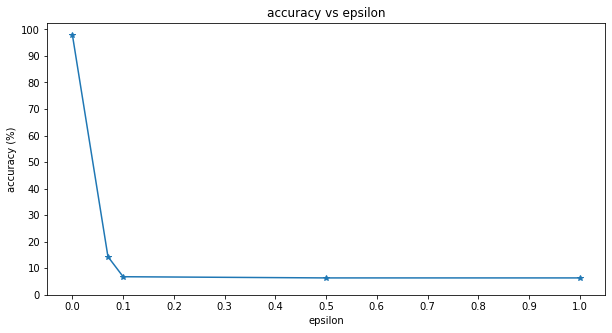

In [ ]:
# evaluate full connected model under PGD attack
adv_pgd_eval_model(fc_model, test_loader)

#### Evaluating convolutional network

iter	epsilon	alpha	accuracy
10	0.000	1e+05	0.98850
10	0.070	1e+05	0.80450
10	0.100	1e+05	0.60840
10	0.500	1e+05	0.42300
10	1.000	1e+05	0.42110


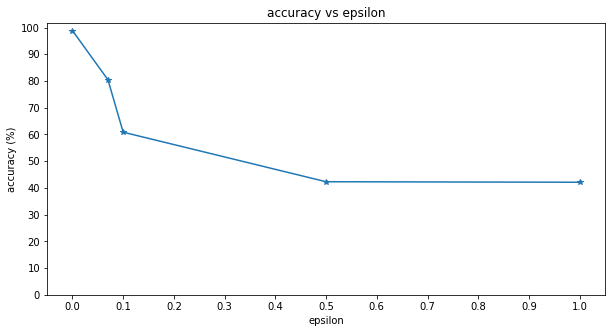

In [ ]:
# evaluate full connected model under PGD attack
adv_pgd_eval_model(conv_model, test_loader)

### Visual aspect of attacked images under PGD

#### Fully connected network 


epsilon = 0.0 



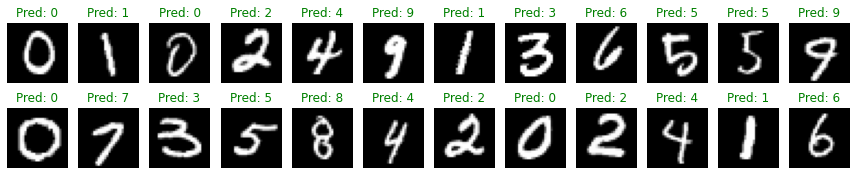


epsilon = 0.07 



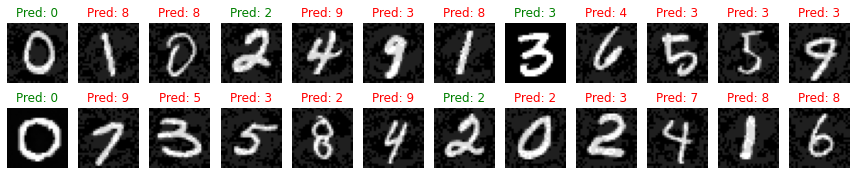


epsilon = 0.1 



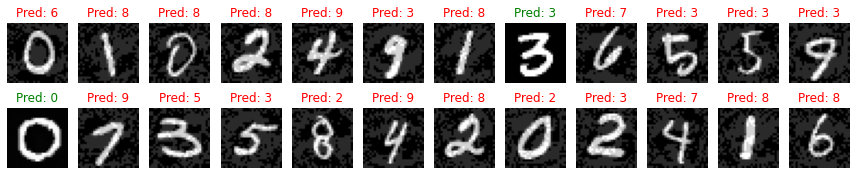


epsilon = 0.5 



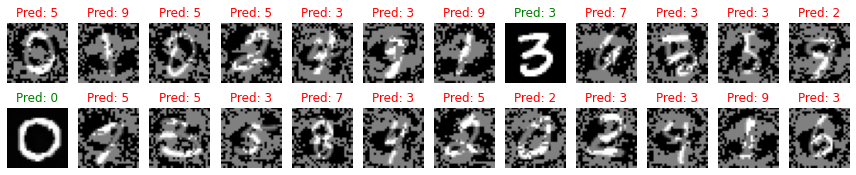


epsilon = 1 



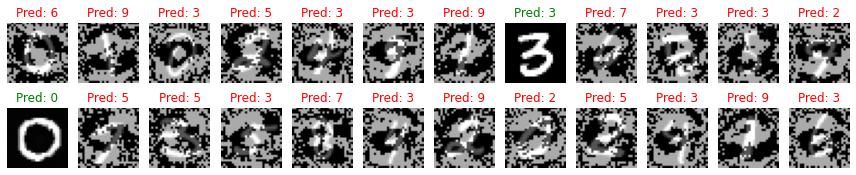

In [ ]:
# display attacked images for each epsilon.
for epsilon in epsilons:
  print('\nepsilon =', epsilon, '\n')

  pgd = ProjectedGradientDescent(model=fc_model, eps=epsilon, alpha=alpha, num_iter=num_iter)
  adv_imgs = pgd.compute(imgs, labels)
  output = fc_model(adv_imgs)

  plot_images(1 - adv_imgs, labels, output, 2, 12)

#### Convolutional network


epsilon = 0.0 



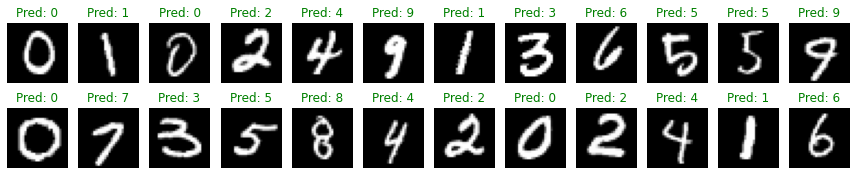


epsilon = 0.07 



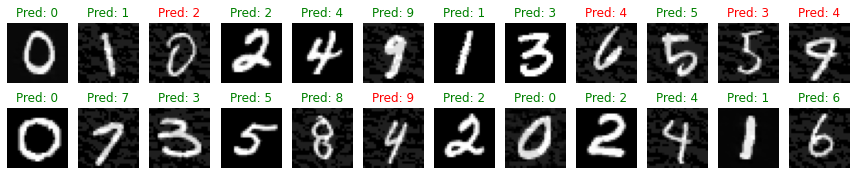


epsilon = 0.1 



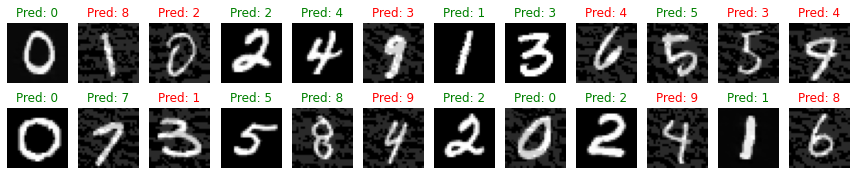


epsilon = 0.5 



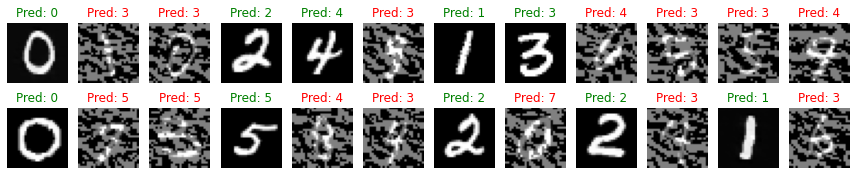


epsilon = 1 



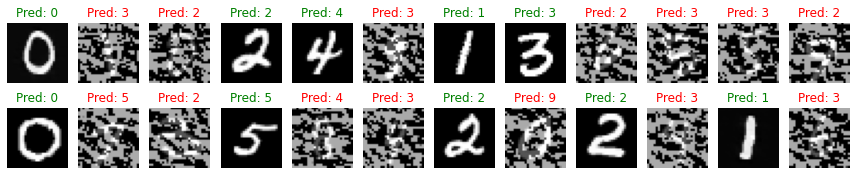

In [ ]:
# display attacked images for each epsilon.
for epsilon in epsilons:
  print('\nepsilon =', epsilon, '\n')

  pgd = ProjectedGradientDescent(model=conv_model, eps=epsilon, alpha=alpha, num_iter=num_iter)
  adv_imgs = pgd.compute(imgs, labels)
  output = conv_model(adv_imgs)

  plot_images(1 - adv_imgs, labels, output, 2, 12)

### Overall discussion on PGD
Visuellement, l'attaque PGD (du moins avec les valeurs de paramètres choisies) semble perturber  plus faiblement les images. Plus étonnant, il semblerait que l'attaque cible plus particulièrement certaines images. Même avec une valeur de $\epsilon$ très forte, certaines images semblent ainsi identiques avant et après perturbation. Nous n'avons creusé l'origine de cette particularité.

A noter que nous avons réalisé des essais en fixant le nombre d'itérations à 10 (la valeur retenue pour l'exemple ci-dessus), 100 et 1,000 et qu'il apparaît que le taux d'erreur des classifieurs est une fonction croissante de ce nombre.

On note finalement que dans l'ensemble, le modèle convolutionnel resiste toujours mieux aux images attaquées que le modèle fully connected (linéaire) pour les mêmes valeurs des hyperparamètres, mais que la dégradation de l'accuracy causée par l'attaque PGD est plus forte que celle observée pour l'attaque FGSM.